# Credit Card Fraud Detection with Autoencoders

In [1]:
#Import Libraries

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

/Users/Georgios/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import Credit Card Data 
df = pd.read_csv("/Users/Georgios/Desktop/creditcard.csv")

# Data exploration

In [3]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Check for missing values:

In [4]:
df.isnull().values.any()

False

Check the size of the classes.

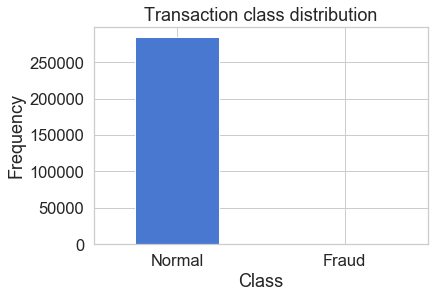

In [5]:
LABELS = ["Normal", "Fraud"] #Create the two labels
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
rcParams['figure.figsize'] = 14, 8
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

As we observe the credit card dataset is highly imbalanced since there are a lot more normal transactions than fraudulent ones.  

In [6]:
#Create subsets by class variable:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [7]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

Lets now see the difference in the amounts of money used in different transaction classes.

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Moreover, we can explore the distributions of the transaction amounts for the two classes.

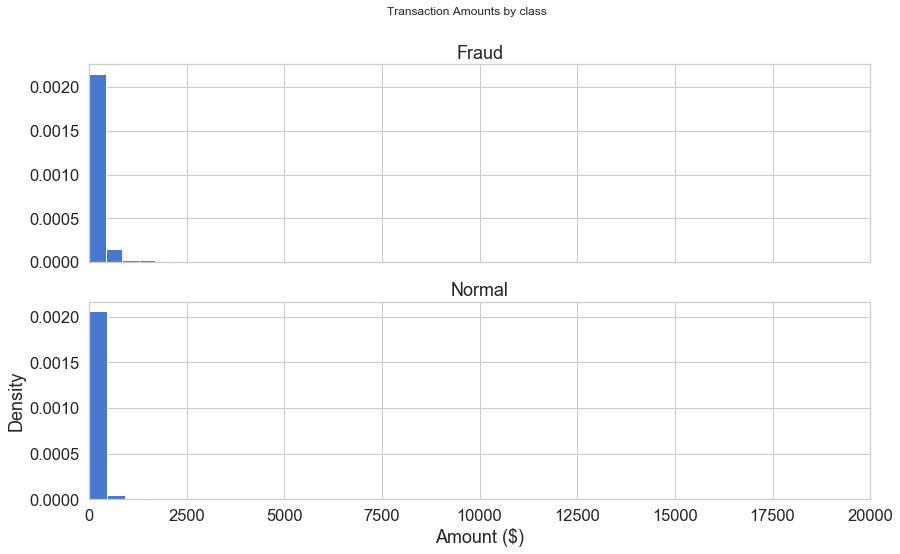

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Transaction Amounts by class')

plt.xlabel('Amount ($)')
plt.ylabel('Density')
plt.xlim((0, 20000))

ax1.hist(frauds.Amount, bins = 5, density=True)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = 55, density=True)
ax2.set_title('Normal')
plt.show();

We observe that both distributions are skewed to the right. 

Next we can compare rough estimates of intensity parameters of exponential distributions of amounts

In [13]:
intensity_normal = 1/np.mean(normal.Amount)
intensity_frauds = 1/np.mean(frauds.Amount)

print('Normal: ',intensity_normal, 'Fraud: ',intensity_frauds)

Normal:  0.011326179860251879 Fraud:  0.008182547988897683


Normal transactions have heavier upper tail than the fraudulent transactions. 
Next, we can compare the classes by time of transaction and amount.

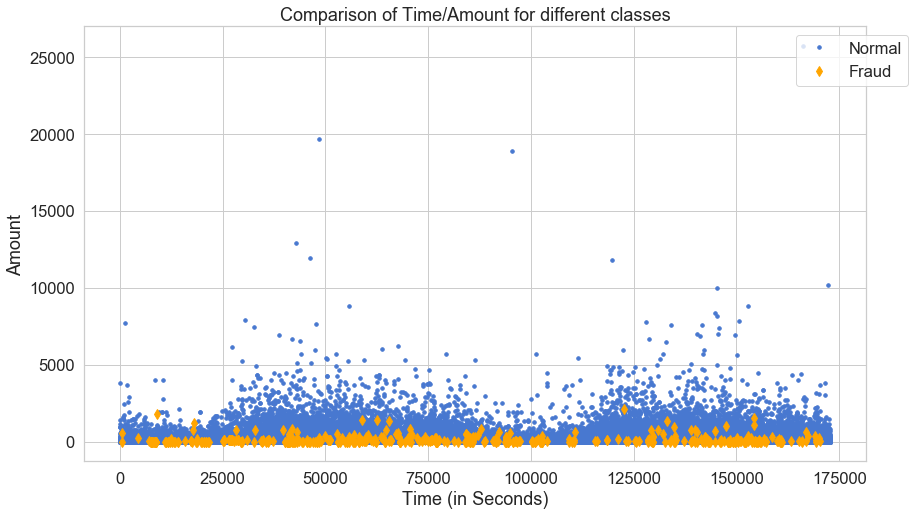

In [14]:
groups = df.groupby('Class')
fig, ax = plt.subplots()
for name, group in groups:
     if name == 1:
         MarkerSize = 7
         Color = 'orange'
         Label = 'Fraud'
         Marker = 'd'
     else:
         MarkerSize = 3.5
         Color = 'b'
         Label = 'Normal'
         Marker = 'o'
     ax.plot(group.Time, group.Amount,
             linestyle='',
             color=Color,
             label=Label,
             ms=MarkerSize,
             marker=Marker)
ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
plt.title("Comparison of Time/Amount for different classes")
plt.ylabel('Amount')
plt.xlabel('Time (in Seconds)')
plt.show();


As we observe the time of transaction does not seem to be important. 

# Data Preparation

In [15]:
df.shape

(284807, 31)

In [16]:
#Drop Time since it does not seem to be important. Scale vAmount with StandardScaler.
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# Training the Autoencoder

In order to train the autoencoder for anomalies detection we will use only normal data.
Then any new observations that cannot be well predicted by the model will be considered to be anomalies.

In [17]:
#Keep 20% of the data for testing purposes. With `stratify` we manage to keep the class size ratio within each data set.
RANDOM_SEED = 42
X_train_split, X_test_split = train_test_split(data, test_size=0.2,
                                   stratify=data['Class'], 
                                   random_state=RANDOM_SEED)

Split into train and test

In [18]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (227845, 29) , shape Y (227845,)
Test: shape X (56962, 29) , shape Y (56962,)


In [19]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [20]:
print(y_train.shape)
print(X_train.shape)

(227845,)
(227845, 29)


In [21]:
X_trainNorm_val.shape

(227451, 29)

# Building the model


In [22]:
#Setting model parameters:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 14
encoder_dim = 7

Create tensors:

In [23]:
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
input_layer:  Tensor("input_1:0", shape=(?, 29), dtype=float32)
encoder1 Tensor("dense_1/Tanh:0", shape=(?, 14), dtype=float32)
encoder2 Tensor("dense_2/Relu:0", shape=(?, 7), dtype=float32)
decoder1 Tensor("dense_3/Tanh:0", shape=(?, 14), dtype=float32)
decoder2 Tensor("dense_4/BiasAdd:0", shape=(?, 29), dtype=float32)


Create autoencoder from the tensors:

In [24]:
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                435       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________


In [26]:
#setting # of epochs and batch size
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) 
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 227451 samples, validate on 56864 samples
Epoch 1/100
227451/227451 [==============================] - 16s 71us/step - loss: 0.5524 - val_loss: 0.4489
Epoch 2/100
227451/227451 [==============================] - 16s 69us/step - loss: 0.4250 - val_loss: 0.4068
Epoch 3/100
227451/227451 [==============================] - 15s 68us/step - loss: 0.4024 - val_loss: 0.3941
Epoch 4/100
227451/227451 [==============================] - 16s 69us/step - loss: 0.3926 - val_loss: 0.3921
Epoch 5/100
227451/227451 [==============================] - 15s 68us/step - loss: 0.3870 - val_loss: 0.3831
Epoch 6/100
227451/227451 [==============================] - 16s 68us/step - loss: 0.3834 - val_loss: 0.3793
Epoch 7/100
227451/227451 [==============================] - 17s 76us/step - loss: 0.3785 - val_loss: 0.3755
Epoch 8/100
227451/227451 [==============================] - 17s 75us/step - loss: 0.3751 - val_loss: 0.3695
Epoc

Load the model saved by checkpointer.

In [27]:
autoencoder = load_model('model.h5')

# Evaluation

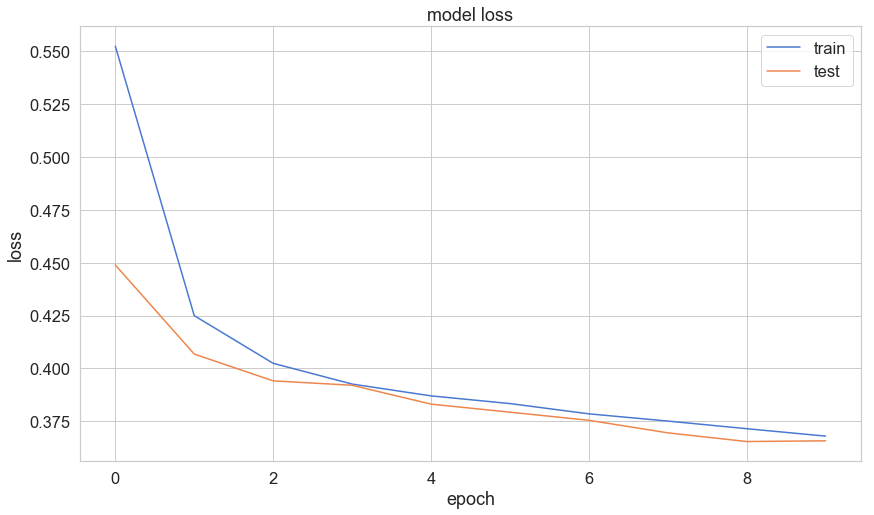

In [28]:
#Plot of the learning process.
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

Next, calculate predictions by the autoencoder:

In [29]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((56962, 29), (56962, 29))

Calculate **mean squared error**.

In [30]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
263020,0.214715,0
11378,0.286044,0
147283,0.602589,0
219439,0.094422,0
36939,0.847605,0


In [31]:
error_df.shape

(56962, 2)

In [32]:
error_df.reconstruction_error.describe()

count    56962.000000
mean         0.404172
std          2.129832
min          0.033664
25%          0.159502
50%          0.238527
75%          0.357519
max        126.951147
Name: reconstruction_error, dtype: float64

## Reconstruction of errors

First , we do that for the normal data.

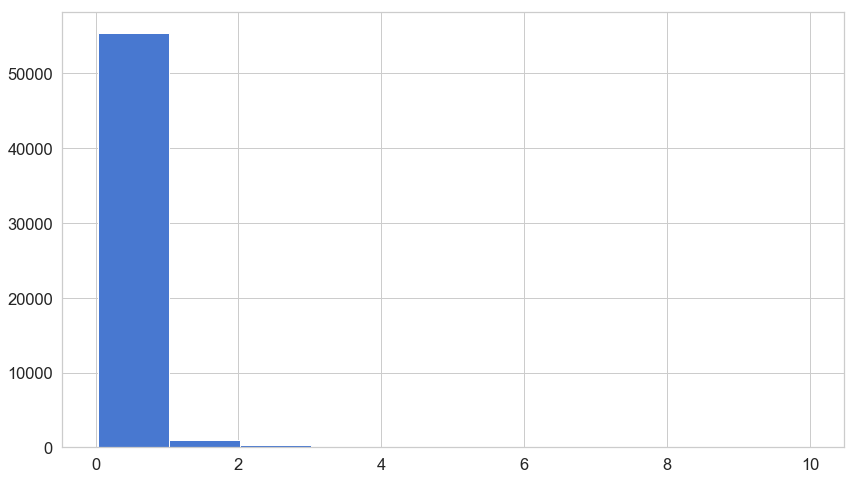

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

Also for the fraudulent data.

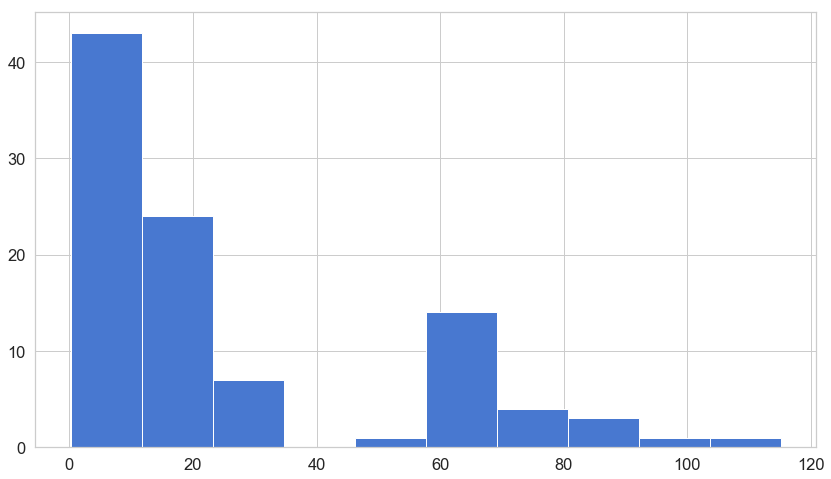

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

Errors of reconstruction for the fraudulent data are larger.

In [35]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

Calculate ROC curve and AUC:

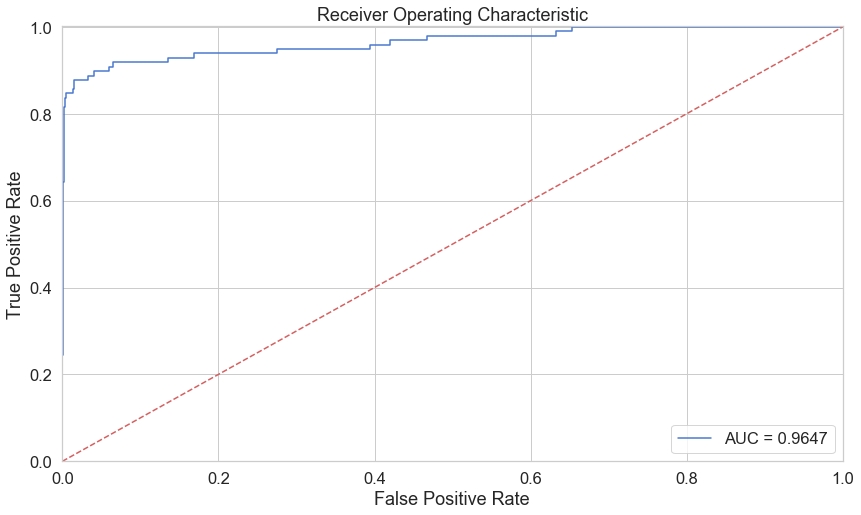

In [36]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

As we see AUC for the autoencoder predictions is very high and close to 1.

# Prediction

We can use prediction MSE to detect fraud by selecting a high level quantile of the MSE sample that guarantees probability of type 1 error. i.e. We can select 0.995 quantile of the reconstruction error for "normal" class.

In [37]:
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

2.7408470244771763

Plot all errors, normal and fraud cases marked, and the threshold:

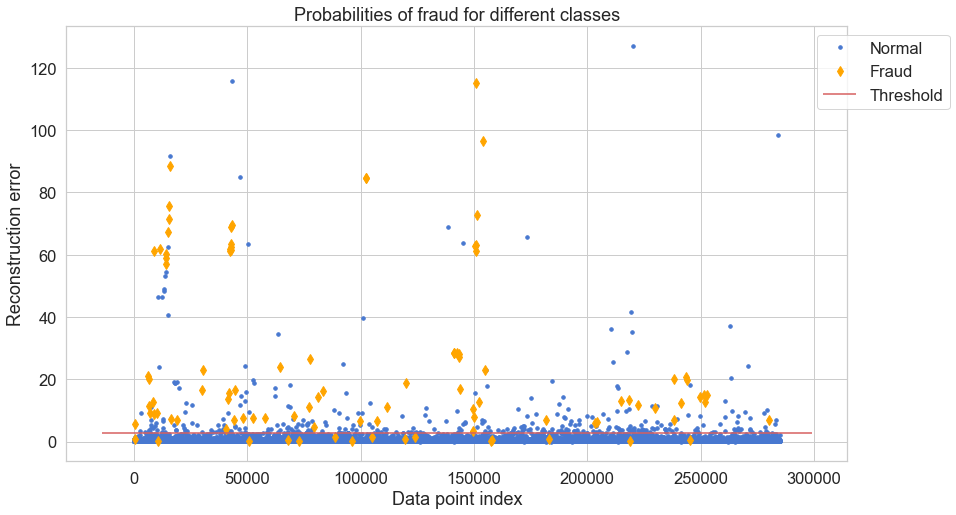

In [39]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 1:
        MarkerSize = 7
        Color = 'orange'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(0.95, 1))
plt.title("Probabilities of fraud for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Lastly we can create a confusion matrix to evaluate how the model predict frauds.

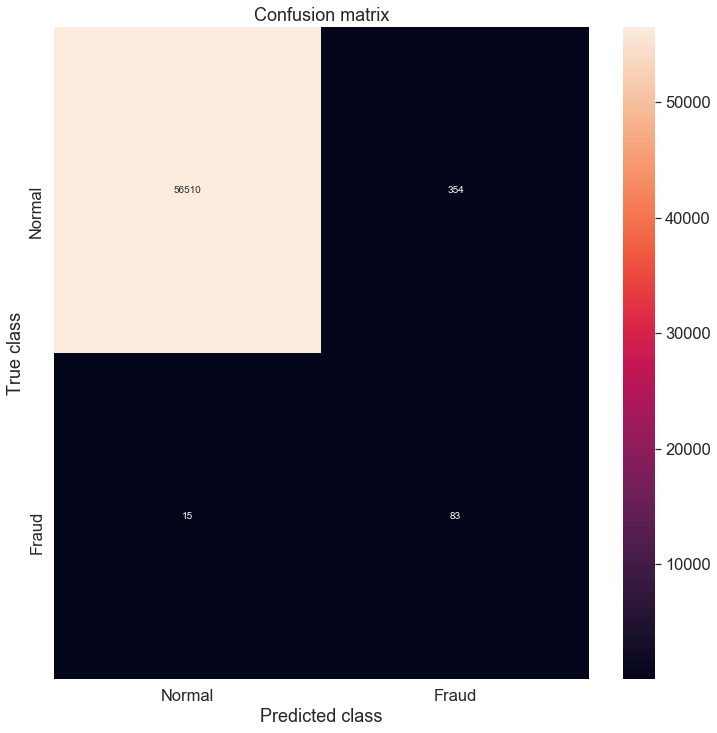

In [40]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [41]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(0.30833638651963025, 0.9935219971208876)

As we see, the model can detect many fraudulent cases at a high accuracy (99,3%). However, because of extreme prevalence Cohen's kappa gives a much more conservative evaluation. 